In [1]:
# Import librabry
import os
import re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from num2words import num2words
import spacy
from deep_translator import GoogleTranslator
from underthesea import text_normalize, classify, sentiment
from wordcloud import WordCloud
import emoji

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import (WordCloud, get_single_color_func)
from joblib import dump

# Read file
cleaned_comment = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "preprocessed", "preprocessed_comment" ,"cleaned_comment_20240408_2129.csv"))

In [2]:
cleaned_comment[["content_comment", "joined_comment", "sentiment_label", "aspect_label"]]

,content_comment,joined_comment,sentiment_label,aspect_label
0,"Giao lâu, chất lượng + đóng gói oke",long quality packaging ok,positive,store
1,"thích em này thật sự, mùi thơm thảo mộc, lành ...",like benign support,positive,smell
2,Toner này gần như ko mùi Dạng sệt thoa lên da ...,odorless thick consistency apply absorb smooth...,positive,texture
3,"Vô thưởng vô phạt, dễ chịu, không mùi Thiết kế...",innocuous pleasant odorless difficult lid design,negative,store
4,giao hàng nhanh với cả xài rất tốt í,fast good,positive,store
...,...,...,...,...
5495,"Dùng xong thấy tóc mềm mượt, màu lên ko rõ lắm...",feel soft smooth color clear worth money,neutral,smoothing
5496,Có nâng nền tóc r nhuộm vẫn fail chắc nhuộm đe...,raise color dye fail guess dye black,negative,others
5497,Tóc mình đen chưa qua nhuộm. Nhuộm màu đen khó...,black dye dye smoke black color black tea s su...,positive,smoothing
5498,"Mau tím đang thịnh nên mua dùng thử, vì là màu...",purple popular buy try safe color not standard...,neutral,others


In [3]:
# Read columns
print(cleaned_comment.columns)

# Drop columns
cleaned_comment = cleaned_comment.drop("Unnamed: 0.1", axis= 1)
cleaned_comment[["joined_comment", "sentiment_label", "aspect_label"]]

Index(['Unnamed: 0.1', 'Unnamed: 0', 'data_product_id', 'content_comment',
       'lower_comment', 'decoded_comment', 'translated_comment',
       'demojized_comment', 'standardlized_comment', 'cleaned_comment',
       'joined_comment', 'sentiment_label', 'aspect_label'],
      dtype='object')


,joined_comment,sentiment_label,aspect_label
0,long quality packaging ok,positive,store
1,like benign support,positive,smell
2,odorless thick consistency apply absorb smooth...,positive,texture
3,innocuous pleasant odorless difficult lid design,negative,store
4,fast good,positive,store
...,...,...,...
5495,feel soft smooth color clear worth money,neutral,smoothing
5496,raise color dye fail guess dye black,negative,others
5497,black dye dye smoke black color black tea s su...,positive,smoothing
5498,purple popular buy try safe color not standard...,neutral,others


In [4]:
# Count sentiment, aspect label
print(cleaned_comment["sentiment_label"].value_counts())
print("\n")
print(cleaned_comment["aspect_label"].value_counts())

sentiment_label
positive    4036
neutral      823
negative     641
Name: count, dtype: int64


aspect_label
texture      1394
others       1364
smoothing    1293
smell         844
store         604
Name: count, dtype: int64


In [5]:
# Slice data
positive_comments = cleaned_comment[cleaned_comment.sentiment_label == "positive"][:1000]
neutral_negative_comments = cleaned_comment[(cleaned_comment.sentiment_label == "neutral") | (cleaned_comment.sentiment_label == "negative")]

# Concat data
comment = pd.concat([positive_comments, neutral_negative_comments])

In [6]:
# Count sentiment, aspect label after slicing data
print(comment["sentiment_label"].value_counts())
print("\n")
print(comment["aspect_label"].value_counts())

sentiment_label
positive    1000
neutral      823
negative     641
Name: count, dtype: int64


aspect_label
others       675
texture      616
smoothing    460
store        380
smell        333
Name: count, dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10188\3179864619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Blues")


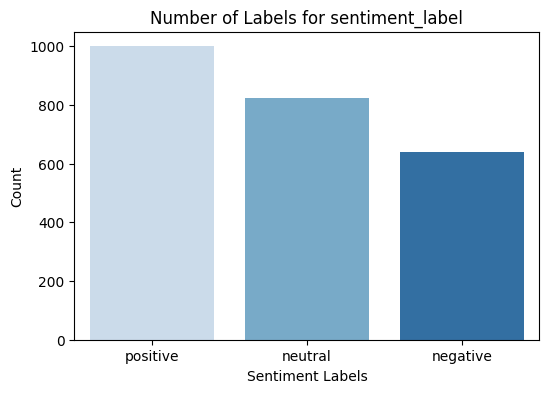

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10188\3179864619.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aspect_counts.index, y=aspect_counts.values, palette="Greens")


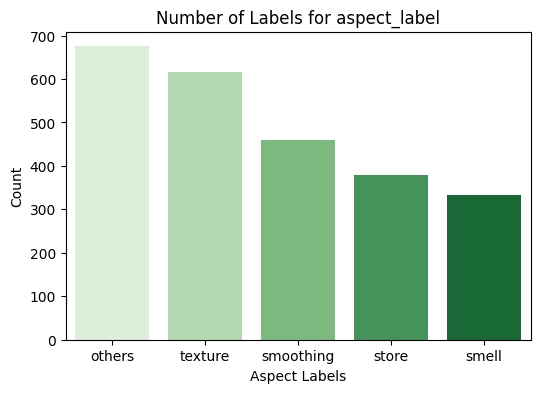

In [7]:
# Sentiment label counts
sentiment_counts = comment["sentiment_label"].value_counts()

# Plot for sentiment_label
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Blues")
plt.title('Number of Labels for sentiment_label')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

# Aspect label counts
aspect_counts = comment["aspect_label"].value_counts()

# Plot for aspect_label
plt.figure(figsize=(6, 4))
sns.barplot(x=aspect_counts.index, y=aspect_counts.values, palette="Greens")
plt.title('Number of Labels for aspect_label')
plt.xlabel('Aspect Labels')
plt.ylabel('Count')
plt.show()

In [8]:
# Split data into train, test
X_train, X_test, y_train_sentiment, y_test_sentiment, y_train_aspect, y_test_aspect = train_test_split(comment['cleaned_comment'], 
                                                                                                       comment['sentiment_label'], 
                                                                                                       comment['aspect_label'], 
                                                                                                       test_size=0.2, 
                                                                                                       random_state=42)

# Initialize and train the TF-IDF model
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
# Khởi tạo đối tượng KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Tạo DataFrame để lưu kết quả
results_for_sentiment = {
    "Fold": [],
    "Logistic Regression": [],
    "Naive Bayes": [],
    "SVM": []
}

results_for_aspect = {
    "Fold": [],
    "Logistic Regression": [],
    "Naive Bayes": [],
    "SVM": []
}

# Hiển thị các fold được tạo ra trong mỗi lần cross-validation
fold_index = 1
for train_index, valid_index in kf.split(X_train):
    # print(f"Fold {fold_index}:")
    # print("Train indices:", train_index)
    # print("Validation indices:", valid_index)
    # print()
    
    # Tạo pipeline cho Logistic Regression
    pipeline_log_reg = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('log_reg', LogisticRegression())
    ])

    # Tạo pipeline cho Multinomial Naive Bayes
    pipeline_nb = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('nb', MultinomialNB())
    ])

    # Tạo pipeline cho SVM
    pipeline_svm = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', SVC(kernel='linear', probability=True))
    ])

     # Huấn luyện và đánh giá mô hình Logistic Regression cho sentiment
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_sentiment_fold, y_valid_sentiment_fold = y_train_sentiment.iloc[train_index], y_train_sentiment.iloc[valid_index]
    
    pipeline_log_reg.fit(X_train_fold, y_train_sentiment_fold)
    accuracy_log_reg_sentiment = round(pipeline_log_reg.score(X_valid_fold, y_valid_sentiment_fold) * 100, 2)
    print("Logistic Regression Accuracy (Sentiment):", accuracy_log_reg_sentiment)
    
    # Huấn luyện và đánh giá mô hình Multinomial Naive Bayes cho sentiment
    pipeline_nb.fit(X_train_fold, y_train_sentiment_fold)
    accuracy_nb_sentiment = round(pipeline_nb.score(X_valid_fold, y_valid_sentiment_fold) * 100, 2)
    print("Multinomial Naive Bayes Accuracy (Sentiment):", accuracy_nb_sentiment)
    
    # Huấn luyện và đánh giá mô hình SVM cho sentiment
    pipeline_svm.fit(X_train_fold, y_train_sentiment_fold)
    accuracy_svm_sentiment = round(pipeline_svm.score(X_valid_fold, y_valid_sentiment_fold) * 100, 2)
    print("SVM Accuracy (Sentiment):", accuracy_svm_sentiment)
    
    # Huấn luyện và đánh giá mô hình Logistic Regression cho aspect
    y_train_aspect_fold, y_valid_aspect_fold = y_train_aspect.iloc[train_index], y_train_aspect.iloc[valid_index]
    
    pipeline_log_reg.fit(X_train_fold, y_train_aspect_fold)
    accuracy_log_reg_aspect = round(pipeline_log_reg.score(X_valid_fold, y_valid_aspect_fold) * 100, 2)
    print("Logistic Regression Accuracy (Aspect):", accuracy_log_reg_aspect)
    
    # Huấn luyện và đánh giá mô hình Multinomial Naive Bayes cho aspect
    pipeline_nb.fit(X_train_fold, y_train_aspect_fold)
    accuracy_nb_aspect = round(pipeline_nb.score(X_valid_fold, y_valid_aspect_fold) * 100, 2)
    print("Multinomial Naive Bayes Accuracy (Aspect):", accuracy_nb_aspect)
    
    # Huấn luyện và đánh giá mô hình SVM cho aspect
    pipeline_svm.fit(X_train_fold, y_train_aspect_fold)
    accuracy_svm_aspect = round(pipeline_svm.score(X_valid_fold, y_valid_aspect_fold) * 100, 2)
    print("SVM Accuracy (Aspect):", accuracy_svm_aspect)

    # Lưu kết quả vào DataFrame cho sentiment
    results_for_sentiment["Fold"].append(fold_index)
    results_for_sentiment["Logistic Regression"].append(accuracy_log_reg_sentiment)
    results_for_sentiment["Naive Bayes"].append(accuracy_nb_sentiment)
    results_for_sentiment["SVM"].append(accuracy_svm_sentiment)

    # Lưu kết quả vào DataFrame cho aspect
    results_for_aspect["Fold"].append(fold_index)
    results_for_aspect["Logistic Regression"].append(accuracy_log_reg_aspect)
    results_for_aspect["Naive Bayes"].append(accuracy_nb_aspect)
    results_for_aspect["SVM"].append(accuracy_svm_aspect)

    fold_index += 1
    print("-" * 50)

# Tạo DataFrame từ kết quả
sentiment_results_df = pd.DataFrame(results_for_sentiment)
aspect_results_df = pd.DataFrame(results_for_aspect)

print("Result for sentiment model:")
print(sentiment_results_df)
print("Result for aspect model:")
print(aspect_results_df)

Logistic Regression Accuracy (Sentiment): 63.64
Multinomial Naive Bayes Accuracy (Sentiment): 56.06
SVM Accuracy (Sentiment): 63.13
Logistic Regression Accuracy (Aspect): 58.59
Multinomial Naive Bayes Accuracy (Aspect): 55.56
SVM Accuracy (Aspect): 61.62
--------------------------------------------------
Logistic Regression Accuracy (Sentiment): 59.39
Multinomial Naive Bayes Accuracy (Sentiment): 53.3
SVM Accuracy (Sentiment): 60.41
Logistic Regression Accuracy (Aspect): 61.93
Multinomial Naive Bayes Accuracy (Aspect): 57.36
SVM Accuracy (Aspect): 64.47
--------------------------------------------------
Logistic Regression Accuracy (Sentiment): 62.94
Multinomial Naive Bayes Accuracy (Sentiment): 58.38
SVM Accuracy (Sentiment): 65.48
Logistic Regression Accuracy (Aspect): 61.42
Multinomial Naive Bayes Accuracy (Aspect): 60.91
SVM Accuracy (Aspect): 59.9
--------------------------------------------------
Logistic Regression Accuracy (Sentiment): 62.94
Multinomial Naive Bayes Accuracy (Se

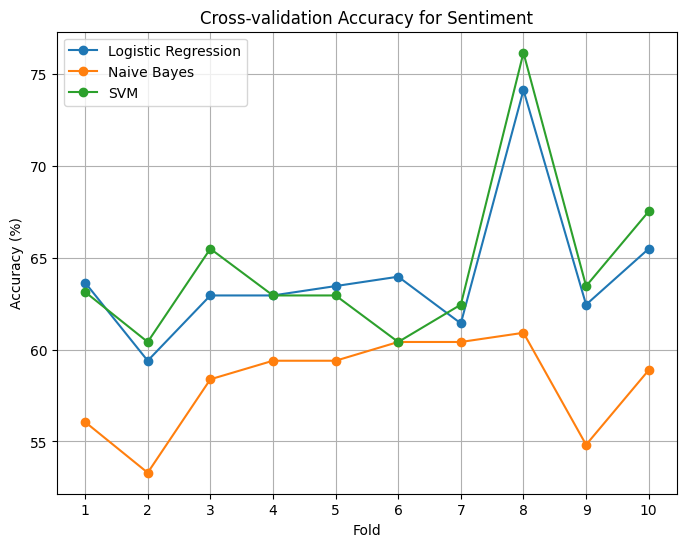

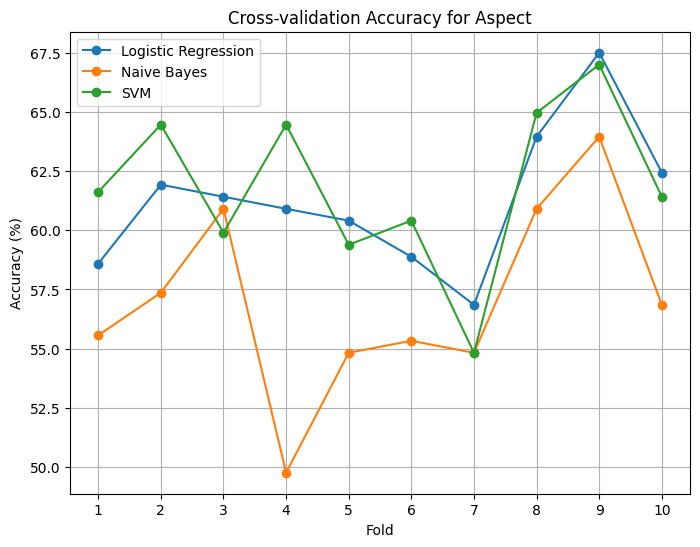

In [10]:
# Lấy thông tin từ DataFrame results
sentiment_fold = results_for_sentiment["Fold"]
sentiment_lr_accuracy = results_for_sentiment["Logistic Regression"]
sentiment_nb_accuracy = results_for_sentiment["Naive Bayes"]
sentiment_svm_accuracy = results_for_sentiment["SVM"]

# Vẽ plot cho sentiment
plt.figure(figsize=(8, 6))
plt.plot(sentiment_results_df["Fold"], sentiment_results_df["Logistic Regression"], marker='o', label='Logistic Regression')
plt.plot(sentiment_results_df["Fold"], sentiment_results_df["Naive Bayes"], marker='o', label='Naive Bayes')
plt.plot(sentiment_results_df["Fold"], sentiment_results_df["SVM"], marker='o', label='SVM')
plt.title('Cross-validation Accuracy for Sentiment')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(sentiment_results_df["Fold"])
plt.legend()
plt.grid(True)
plt.show()

# Vẽ plot cho aspect
plt.figure(figsize=(8, 6))
plt.plot(aspect_results_df["Fold"], aspect_results_df["Logistic Regression"], marker='o', label='Logistic Regression')
plt.plot(aspect_results_df["Fold"], aspect_results_df["Naive Bayes"], marker='o', label='Naive Bayes')
plt.plot(aspect_results_df["Fold"], aspect_results_df["SVM"], marker='o', label='SVM')
plt.title('Cross-validation Accuracy for Aspect')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(aspect_results_df["Fold"])
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Tính giá trị trung bình của mỗi mô hình của sentiment
sentiment_mean_accuracy = {
    "Model Name": [],
    "Mean_Accuracy": []
}

for model_name in ["Logistic Regression", "Naive Bayes", "SVM"]:
    sentiment_mean_accuracy["Model Name"].append(model_name)
    sentiment_mean_accuracy["Mean_Accuracy"].append(round(sentiment_results_df[model_name].mean(), 2))
print("Mean_Accuracy for sentiment")
sentiment_mean_accuracy_df = pd.DataFrame(sentiment_mean_accuracy)
print(sentiment_mean_accuracy_df)

# Tính giá trị trung bình của mỗi mô hình của aspect
aspect_mean_accuracy = {
    "Model Name": [],
    "Mean_Accuracy": []
}

for model_name in ["Logistic Regression", "Naive Bayes", "SVM"]:
    aspect_mean_accuracy["Model Name"].append(model_name)
    aspect_mean_accuracy["Mean_Accuracy"].append(round(aspect_results_df[model_name].mean(), 2))
print("Mean_Accuracy for aspect")
aspect_mean_accuracy_df = pd.DataFrame(aspect_mean_accuracy)
print(aspect_mean_accuracy_df)

Mean_Accuracy for sentiment
            Model Name  Mean_Accuracy
0  Logistic Regression          63.98
1          Naive Bayes          58.20
2                  SVM          64.48
Mean_Accuracy for aspect
            Model Name  Mean_Accuracy
0  Logistic Regression          61.29
1          Naive Bayes          57.03
2                  SVM          61.85


In [12]:
# Initialize and train the SVM model for sentiment_label
svm_model_sentiment = SVC(kernel='linear', probability=True)  # Using linear kernel for text classification
svm_model_sentiment.fit(X_train_tfidf, y_train_sentiment)

# Initialize and train the SVM model for aspect_label
svm_model_aspect = SVC(kernel='linear', probability=True)  # Using linear kernel for text classification
svm_model_aspect.fit(X_train_tfidf, y_train_aspect)

# Predict on the test set for sentiment_label
y_pred_sentiment = svm_model_sentiment.predict(X_test_tfidf)

# Predict on the test set for aspect_label
y_pred_aspect = svm_model_aspect.predict(X_test_tfidf)

# Evaluate the accuracy of the sentiment_label model
accuracy_sentiment = accuracy_score(y_test_sentiment, y_pred_sentiment)
print("Accuracy for sentiment_label model:", accuracy_sentiment)

# Evaluate the accuracy of the aspect_label model
accuracy_aspect = accuracy_score(y_test_aspect, y_pred_aspect)
print("Accuracy for aspect_label model:", accuracy_aspect)

# # Save the TF-IDF vectorizer
# dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

# # Save the SVM model for sentiment_label
# dump(svm_model_sentiment, 'svm_model_sentiment.joblib')

# # Save the SVM model for aspect_label
# dump(svm_model_aspect, 'svm_model_aspect.joblib')

Accuracy for sentiment_label model: 0.6835699797160243
Accuracy for aspect_label model: 0.5983772819472617


In [13]:
# Calculate F1-score for sentiment_label
f1_score_sentiment = f1_score(y_test_sentiment, y_pred_sentiment, labels=["positive", "neutral", "negative"], average=None)
print("F1-score for sentiment_label:")
for label, score in zip(["positive", "neutral", "negative"], f1_score_sentiment):
    print(f"{label}: {score}")

# Calculate F1-score for aspect_label
f1_score_aspect = f1_score(y_test_aspect, y_pred_aspect, labels=["others", "texture", "smoothing", "store", "smell"], average=None)
print("\nF1-score for aspect_label:")
for label, score in zip(["others", "texture", "smoothing", "store", "smell"], f1_score_aspect):
    print(f"{label}: {score}")

F1-score for sentiment_label:
positive: 0.7598944591029023
neutral: 0.6588235294117647
negative: 0.6067415730337079

F1-score for aspect_label:
others: 0.5944055944055944
texture: 0.597864768683274
smoothing: 0.49295774647887325
store: 0.6518518518518519
smell: 0.6619718309859155


In [14]:
# Create dataframe for predictions with original comments
predictions_df = pd.DataFrame({
    'original_Comment': comment.loc[X_test.index, 'content_comment'],  # Get original comments based on X_test index
    'cleaned_Comment': comment.loc[X_test.index, 'joined_comment'],  # Assuming X_test contains the cleaned comments
    'actual_Sentiment': y_test_sentiment,
    'predicted_Sentiment': y_pred_sentiment,
    'actual_Aspect': y_test_aspect,
    'predicted_Aspect': y_pred_aspect
})

In [15]:
# Print the dataframe
print("Predictions:")
predictions_df.tail()

Predictions:


,original_Comment,cleaned_Comment,actual_Sentiment,predicted_Sentiment,actual_Aspect,predicted_Aspect
3650,"Sản phẩm không màu , k nâng tông , dưỡng ẩm nh...",colorless enhance tone moisturize lot find shi...,negative,neutral,others,texture
3658,"kcn thấm nhanh nhưng mà dễ bị xê dịch, trôi đi...",absorb quickly easily move wash away wear mask...,neutral,negative,smell,smell
3401,Đã mua offline. Serum t thấy đặc hơn nước xíu....,buy offline feel little thick water tiny blist...,negative,negative,texture,texture
2425,E này gía có hơi cao. Nhg xài tốt. Chất kem lỏ...,bit high good liquid slight tone enhancement c...,neutral,positive,texture,texture
920,"chất dịu nhẹ, tẩy trang hằng ngày oke. không c...",gentle substance ok daily remover not ste not ...,neutral,neutral,smell,smell


In [16]:
predictions_df[['cleaned_Comment', 'predicted_Sentiment', 'predicted_Aspect']]

,cleaned_Comment,predicted_Sentiment,predicted_Aspect
157,new version not hightone old version thin ligh...,neutral,texture
4888,smell good mother quickly get greasy wash thor...,negative,texture
941,fast order 11 deliver 2 pm vote star,neutral,store
72,ok like,positive,others
1183,quality,neutral,others
...,...,...,...
3650,colorless enhance tone moisturize lot find shi...,neutral,texture
3658,absorb quickly easily move wash away wear mask...,negative,smell
3401,buy offline feel little thick water tiny blist...,negative,texture
2425,bit high good liquid slight tone enhancement c...,positive,texture


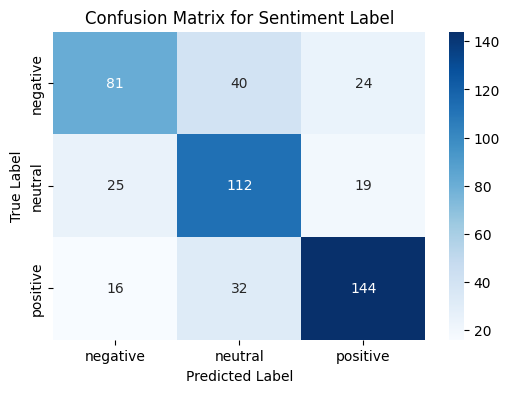

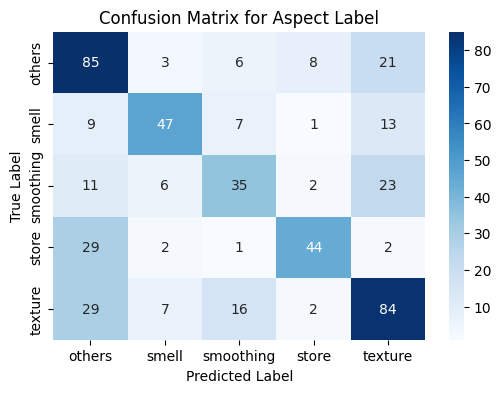

In [17]:
# Calculate confusion matrix for sentiment_label
conf_matrix_sentiment = confusion_matrix(y_test_sentiment, y_pred_sentiment)

# Plot confusion matrix for sentiment_label
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_sentiment, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model_sentiment.classes_, yticklabels=svm_model_sentiment.classes_)
plt.title('Confusion Matrix for Sentiment Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate confusion matrix for aspect_label
conf_matrix_aspect = confusion_matrix(y_test_aspect, y_pred_aspect)

# Plot confusion matrix for aspect_label
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_aspect, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model_aspect.classes_, yticklabels=svm_model_aspect.classes_)
plt.title('Confusion Matrix for Aspect Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
# Generate classification report for sentiment_label
classification_report_sentiment = classification_report(y_test_sentiment, y_pred_sentiment, labels=["positive", "neutral", "negative"])
print("Classification Report for sentiment_label:")
print(classification_report_sentiment)

# Generate classification report for aspect_label
classification_report_aspect = classification_report(y_test_aspect, y_pred_aspect, labels=["others", "texture", "smoothing", "store", "smell"])
print("\nClassification Report for aspect_label:")
print(classification_report_aspect)

Classification Report for sentiment_label:
              precision    recall  f1-score   support

    positive       0.77      0.75      0.76       192
     neutral       0.61      0.72      0.66       156
    negative       0.66      0.56      0.61       145

    accuracy                           0.68       493
   macro avg       0.68      0.68      0.68       493
weighted avg       0.69      0.68      0.68       493


Classification Report for aspect_label:
              precision    recall  f1-score   support

      others       0.52      0.69      0.59       123
     texture       0.59      0.61      0.60       138
   smoothing       0.54      0.45      0.49        77
       store       0.77      0.56      0.65        78
       smell       0.72      0.61      0.66        77

    accuracy                           0.60       493
   macro avg       0.63      0.59      0.60       493
weighted avg       0.61      0.60      0.60       493



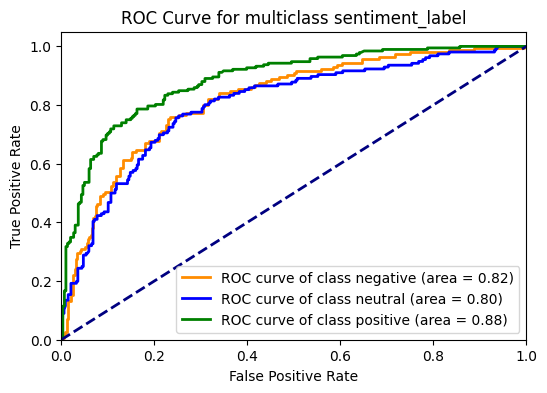

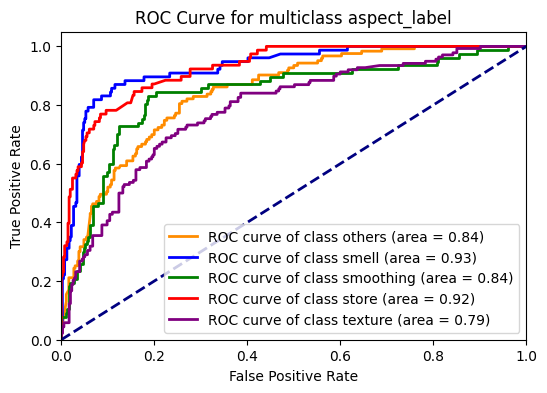

In [19]:
# Predict probabilities on the test set for sentiment_label
y_prob_sentiment = svm_model_sentiment.predict_proba(X_test_tfidf)

# Compute ROC curve and ROC area for each sentiment_label class
fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(svm_model_sentiment.classes_):
    fpr[label], tpr[label], _ = roc_curve(y_test_sentiment == label, y_prob_sentiment[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot ROC curve for each sentiment_label class
plt.figure(figsize=(6, 4))
colors = ['darkorange', 'blue', 'green']  # Add more colors if you have more classes
for label, color in zip(svm_model_sentiment.classes_, colors):
    plt.plot(fpr[label], tpr[label], color=color, lw=2, label=f'ROC curve of class {label} (area = {roc_auc[label]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for multiclass sentiment_label')
plt.legend(loc="lower right")
plt.show()

# Predict probabilities on the test set for aspect_label
y_prob_aspect = svm_model_aspect.predict_proba(X_test_tfidf)

# Compute ROC curve and ROC area for each aspect_label class
fpr_aspect = {}
tpr_aspect = {}
roc_auc_aspect = {}

for i, label in enumerate(svm_model_aspect.classes_):
    fpr_aspect[label], tpr_aspect[label], _ = roc_curve(y_test_aspect == label, y_prob_aspect[:, i])
    roc_auc_aspect[label] = auc(fpr_aspect[label], tpr_aspect[label])

# Plot ROC curve for each aspect_label class
plt.figure(figsize=(6, 4))
colors = ['darkorange', 'blue', 'green', 'red', 'purple']  # Add more colors if you have more classes
for label, color in zip(svm_model_aspect.classes_, colors):
    plt.plot(fpr_aspect[label], tpr_aspect[label], color=color, lw=2, label=f'ROC curve of class {label} (area = {roc_auc_aspect[label]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for multiclass aspect_label')
plt.legend(loc="lower right")
plt.show() 

In [20]:
# List of stopwords
custom_stopwords = [
        "makeup", "skincare", "beauty", "cosmetics", "lotion", "serum", "moisturizer", "foundation", "lipstick", "mascara",
        "eyeliner", "blush", "concealer", "highlighter", "eyeshadow", "lip", "face", "eyes", "skin", "hair", "brush", "powder",
        "cream", "gel", "toner", "cleanser", "exfoliator", "primer", "sunscreen", "toning", "cleansing", "exfoliating", "hydrating",
        "soothing", "brightening", "anti-aging", "wrinkle", "acne", "pore", "oily", "dry", "sensitive", "combination", "matte",
        "glossy", "shimmer", "natural", "organic", "vegan", "cruelty-free", "fragrance", "scent", "perfume", "cologne", "aroma",
        "essence", "floral", "fruity", "woody", "musk", "vanilla", "jasmine", "rose", "lavender", "citrus", "patchouli",
        "sandalwood", "bergamot", "amber", "oud", "aquatic", "oriental", "gourmand", "spicy", "fresh", "clean", "sweet",
        "floral", "woody", "fruity", "citrusy", "powdery", "green", "herbal", "aromatic", "musky", "sensual", "romantic",
        "exotic", "elegant", "modern", "classic", "sophisticated", "feminine", "masculine", "unisex", "alluring", "captivating",
        "product", "moisturize", "type", "buy", "use",
        "buy", "sell", "online", "commerce", "store", "shop", "purchase", "transaction", "customer", "seller",
        "retail", "e-commerce", "shopping", "sale", "product", "item", "cart", "checkout", "payment", "order",
        "delivery", "shipping", "warehouse", "inventory", "stock", "price", "discount", "deal", "offer", "promotion",
        "coupon", "voucher", "rebate", "refund", "return", "exchange", "warranty", "guarantee", "consumer", "buyer",
        "merchant", "market", "marketplace", "platform", "website", "app", "mobile", "digital", "virtual", "storefront",
        "shopfront", "retail", "shopkeeper", "checkout", "cashier", "payment", "transaction", "shipping", "delivery",
        "order", "basket", "sale", "purchase", "product", "item", "stock", "buying", "selling", "online", "commerce",
        "store", "shop", "purchasing", "customer", "seller", "retail", "e-commerce", "shopping", "sales", "products",
        "items", "carts", "checkout", "payments", "orders", "deliveries", "shipping", "warehouses", "inventories",
        "stocks", "prices", "discounts", "deals", "offers", "promotions", "coupons", "vouchers", "rebates", "refunds",
        "returns", "exchanges", "warranties", "guarantees", "consumers", "buyers", "sellers", "merchants", "markets",
        "marketplaces", "platforms", "websites", "apps", "mobiles", "digitals", "virtuals", "storefronts", "shopfronts",
        "retails", "shopkeepers", "checkouts", "cashiers", "payments", "transactions", "shippings", "deliveries",
        "orders", "baskets", "sales", "purchases", "products", "items", "stocks", "buy", "sell", "online", "commerce",
        "store", "shop", "purchase", "transaction", "customer", "seller", "retail", "e-commerce", "shopping", "sale",
        "product", "item", "cart", "checkout", "payment", "order", "delivery", "shipping", "warehouse", "inventory",
        "stock", "price", "discount", "deal", "offer", "promotion", "coupon", "voucher", "rebate", "refund", "return",
        "exchange", "warranty", "guarantee", "consumer", "buyer", "merchant", "market", "marketplace", "platform",
        "website", "app", "mobile", "digital", "virtual", "storefront", "shopfront", "retail", "shopkeeper", "checkout",
        "cashier", "payment", "transaction", "shipping", "delivery", "order", "basket", "sale", "purchase", "product",
        "item", "stock"
    ]

# Read abbreviation dictionary file
abbs_df = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "abbreviations.csv"))
abbreviation_dict = dict(zip(abbs_df['abbreviation'], abbs_df['meaning']))

# Create Preprocessing function
def preprocessing_text(comments_list):
    cleaned_comments = []  # List to store the cleaned comments

    # Function to decode abbreviations in text
    def decode_abbreviations(text, abbreviation_dict):
        for abbreviation, meaning in abbreviation_dict.items():
            text = re.sub(r'\b' + re.escape(abbreviation) + r'\b', meaning, text)
        return text

    # Function to translate Vietnamese text to English
    def translate_batch_vietnamese_to_english(texts):
        translated_texts = GoogleTranslator(source='vi', target='en').translate_batch(texts)
        return translated_texts

    # Function to convert emojis to text
    def demojize_if_str(text):
        if isinstance(text, str):
            return emoji.demojize(text)
        else:
            return text

    # Function to remove special characters from text
    def remove_special_characters(text):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Load English language model for lemmatization
    nlp = spacy.load("en_core_web_sm")
    stop_words_spacy = set(nlp.Defaults.stop_words)

    # Combine spaCy stop words with custom stop words
    stop_words_combined = stop_words_spacy.union(custom_stopwords)

    # Function to tokenize text and convert numbers to words
    def tokenize_and_convert_numbers(text):
        tokens = text.split()
        tokens = [num2words(token) if token.isdigit() else token for token in tokens]
        return tokens

    # Function to lemmatize text
    def lemmatize_text(text):
        tokens = tokenize_and_convert_numbers(text)
        tokens = [token.lemma_ for token in nlp(' '.join(tokens)) if isinstance(token, str) or token.text.lower() not in stop_words_combined]
        return tokens
    
    # Iterate through each comment in the list
    for comment in comments_list:
        lower_comment = comment.lower()
        decoded_comment = decode_abbreviations(lower_comment, abbreviation_dict)
        translated_comment = translate_batch_vietnamese_to_english([decoded_comment])[0]
        demojized_comment = demojize_if_str(translated_comment)
        standardized_comment = remove_special_characters(demojized_comment)
        cleaned_comment = lemmatize_text(standardized_comment)
        cleaned_comments.append(' '.join(cleaned_comment))  # Append the cleaned comment to the list

    return cleaned_comments  # Return the list of cleaned comments

In [21]:
# Example of predicting a single sentence
example_sentence = ["Mình mua cho btrai thấy bảo thoa lên mặt một lúc là nó mát mát lạnh lạnh như có bạc hà ý, Bọt khá nhiều nên khi sd m.n nên hạn chế dùng nhiều k sẽ dễ khô da, rửa sạch mặt, nch là okila. M.n có thể tham khảo nhé. Thank shop có nhu cầu sẽ tiếp tục ủng hộ ❤️"]

# Preprocess the example sentence
preprocessed_example = preprocessing_text(example_sentence)

# Convert the preprocessed example to TF-IDF vector
example_tfidf = tfidf_vectorizer.transform(preprocessed_example)

# Predict sentiment label
predicted_sentiment = svm_model_sentiment.predict(example_tfidf)
print("Predicted sentiment label:", predicted_sentiment[0])

# Predict aspect label
predicted_aspect = svm_model_aspect.predict(example_tfidf)
print("Predicted aspect label:", predicted_aspect[0])

Predicted sentiment label: positive
Predicted aspect label: texture


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10188\3966856738.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_Sentiment', data=predictions_df, palette='viridis')


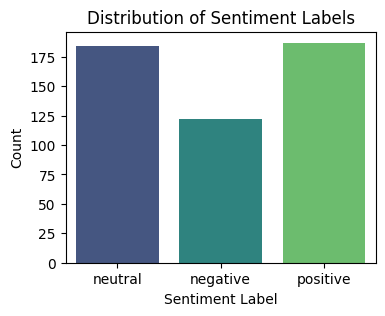

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10188\3966856738.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_Aspect', data=predictions_df, palette='magma')


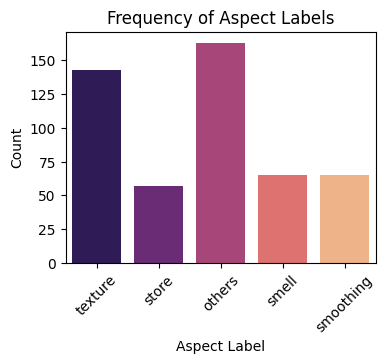

In [22]:
# Biểu đồ 1: Phân phối của nhãn cảm xúc
plt.figure(figsize=(4, 3))
sns.countplot(x='predicted_Sentiment', data=predictions_df, palette='viridis')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

# Biểu đồ 2: Tần suất của các nhãn khía cạnh
plt.figure(figsize=(4, 3))
sns.countplot(x='predicted_Aspect', data=predictions_df, palette='magma')
plt.title('Frequency of Aspect Labels')
plt.xlabel('Aspect Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

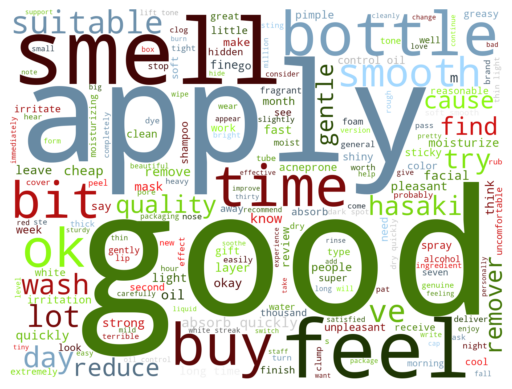

In [23]:
# Biểu đồ 3: Word Cloud của các từ khóa trong bình luận
# Tạo một danh sách các từ khóa từ cột 'cleaned_Comment'
predictions_df['cleaned_Comment'] = predictions_df['cleaned_Comment'].astype(str)
all_keywords = ' '.join(predictions_df['cleaned_Comment']).split()

# Tạo danh sách các nhãn cảm xúc cho từng từ
keyword_sentiments = {}
for index, row in predictions_df.iterrows():
    tokens = row['cleaned_Comment'].split()
    label = row['predicted_Sentiment']
    for token in tokens:
        if token not in keyword_sentiments:
            keyword_sentiments[token] = {'positive': 0, 'negative': 0, 'neutral': 0}
        keyword_sentiments[token][label] += 1

# Tạo dictionary color_to_words
color_to_words = {}
for keyword, sentiments in keyword_sentiments.items():
    max_sentiment = max(sentiments, key=sentiments.get)
    if max_sentiment == 'positive':
        color_to_words.setdefault('#79D70F', []).append(keyword)
    elif max_sentiment == 'negative':
        color_to_words.setdefault('#DA1212', []).append(keyword)
    else:
        color_to_words.setdefault('#A3D8FF', []).append(keyword)

class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)
# Create text from keywords
text = ' '.join(all_keywords)

# Since the text is small collocations are turned off and text is lower-cased
wc = WordCloud(width=1600, height= 1200, background_color='white').generate(text.lower())

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

# Plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

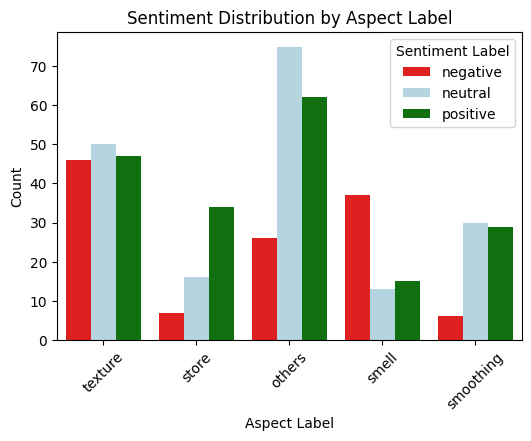

In [24]:
# Biểu đồ 4: Phân phối của các cảm xúc theo từng loại nhãn khía cạnh
plt.figure(figsize=(6,4))
sns.countplot(x='predicted_Aspect', hue='predicted_Sentiment', hue_order=['negative', 'neutral', 'positive'], data=predictions_df, palette={"neutral": "lightblue", "negative": 'red', "positive": "green"})
plt.title('Sentiment Distribution by Aspect Label')
plt.xlabel('Aspect Label')
plt.ylabel('Count')
plt.legend(title='Sentiment Label')
plt.xticks(rotation=45)
plt.show()

In [25]:
predictions_df[["cleaned_Comment", "predicted_Sentiment", "predicted_Aspect"]]

,cleaned_Comment,predicted_Sentiment,predicted_Aspect
157,new version not hightone old version thin ligh...,neutral,texture
4888,smell good mother quickly get greasy wash thor...,negative,texture
941,fast order 11 deliver 2 pm vote star,neutral,store
72,ok like,positive,others
1183,quality,neutral,others
...,...,...,...
3650,colorless enhance tone moisturize lot find shi...,neutral,texture
3658,absorb quickly easily move wash away wear mask...,negative,smell
3401,buy offline feel little thick water tiny blist...,negative,texture
2425,bit high good liquid slight tone enhancement c...,positive,texture


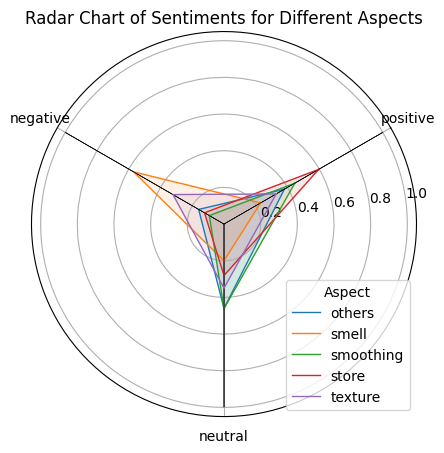

In [26]:
# Biểu đồ: Radar chart
# Sắp xếp theo thứ tự positive, neutral, negative
sentiment_aspect_avg = predictions_df.groupby('predicted_Aspect')['predicted_Sentiment'] \
                          .value_counts(normalize=True).unstack()
sentiment_order = ['positive', 'neutral', 'negative']
sentiment_aspect_avg = sentiment_aspect_avg.reindex(columns=sentiment_order)

# Tạo radar chart duy nhất
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi/6)
ax.set_theta_direction(-1)

# Số sentiment
num_sentiments = len(sentiment_aspect_avg.columns)

# Tạo góc cho mỗi sentiment
angles = np.linspace(0, 2 * np.pi, num_sentiments, endpoint=False).tolist()  # Loại bỏ giá trị cuối cùng
angles.append(angles[0])  # Thêm góc cuối cùng để kết nối với góc đầu tiên

# Tên của các sentiment để đặt nhãn cho các góc
sentiment_names = sentiment_aspect_avg.columns.tolist()

# Vẽ radar chart cho mỗi aspect
for aspect in sentiment_aspect_avg.index:

    # Tạo shape layout
    for i, (name, angle) in enumerate(zip(sentiment_names, angles)):
        ax.plot([angle, angle], [0, 1], color='black', linewidth=0.25)  # Vẽ các đường từ trung tâm đến biên

    # Lấy giá trị sentiment cho aspect hiện tại
    values = sentiment_aspect_avg.loc[aspect].values.tolist()
    values.append(values[0])  # Thêm giá trị cuối cùng để kết nối với giá trị đầu tiên

    # Vẽ radar chart cho aspect hiện tại
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=aspect)
    ax.fill(angles, values, alpha=0.1)

# Đặt nhãn cho các góc
ax.set_xticks(angles[:-1])  # Loại bỏ góc cuối cùng (đã thêm vào để kết nối)
ax.set_xticklabels(sentiment_names)

# Hiển thị legend
plt.legend(title='Aspect', loc='lower right')

plt.title('Radar Chart of Sentiments for Different Aspects')
plt.show()